# Лабораторная работа №3 - Store Sales - Time Series Forecasting

In [53]:
from sklearnex import patch_sklearn
import warnings
warnings.filterwarnings("ignore")

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Препроцессинг, функции для загрузки данных

In [54]:
import pandas as pd
import numpy as np

input_path = "../input/store-sales-time-series-forecasting"

# store_nbr, city, state, type, cluster
stores = pd.read_csv(f"{input_path}/stores.csv")
# date, dcoilwtico
oil = pd.read_csv(f"{input_path}/oil.csv")
# date, store_nbr, transactions
transactions = pd.read_csv(f"{input_path}/transactions.csv")
# date, type, locale, locale_name, description, transferred
holidays_events = pd.read_csv(f"{input_path}/holidays_events.csv")


In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

RANDOM_STATE = 1234567890

def encode(data, array: list[str]):
    for column in array:
        le = LabelEncoder()
        le.fit(data[column])
        encoded_title = le.transform(data[column])
        data[column] = encoded_title

def get_data(path: str):
    # ValueError: Found input variables with inconsistent numbers of samples: [3054348, 3000888]
    data = pd.read_csv(f"{input_path}/{path}.csv")

    # if there is sales column, drop it
    if "sales" in data.columns:
        data = data.drop(columns=["sales"])

    store_nbr_column = data["store_nbr"]
    store_column = stores["store_nbr"].searchsorted(store_nbr_column)
    data["store_city"] = stores["city"][store_column].values
    data["store_state"] = stores["state"][store_column].values
    data["store_type"] = stores["type"][store_column].values
    data["store_cluster"] = stores["cluster"][store_column].values

    # date
    dates_column = data["date"]
    data["oil_price_at_date"] = np.nan
    for i in range(len(dates_column)):
        date = dates_column[i]
        oil_date = oil["date"].searchsorted(date)
        if oil_date == len(oil):
            oil_date -= 1
        data.at[i, "oil_price_at_date"] = oil["dcoilwtico"][oil_date]

    data["oil_price_at_date"] = data["oil_price_at_date"].fillna(data["oil_price_at_date"].median())

    data["date"] = pd.to_datetime(data["date"])
    data["year"] = data["date"].dt.year
    data["month"] = data["date"].dt.month
    data["day"] = data["date"].dt.day
    data["dayofweek"] = data["date"].dt.dayofweek
    data["dayofyear"] = data["date"].dt.dayofyear   
    data["weekofyear"] = data["date"].dt.isocalendar().week
    data["quarter"] = data["date"].dt.quarter

    data = data.drop(columns=["id", "date"])

    encode(data, ["store_city", "store_state", "store_type", "store_cluster", "family"])
    
    return data

def grid_search(model, params, X, y):
    grid_search = GridSearchCV(
        model,
        params,
        refit=True,
        cv=5,
        verbose=1,
        n_jobs=-1,
        return_train_score=True,
    )
    grid_search.fit(X, y)

    print(f"\n\033[92mModel:\033[0m {model.__class__.__name__}")
    print(f"\033[92mBest params:\033[0m {grid_search.best_params_}")
    print(f"\033[92mTrain score:\033[0m {grid_search.cv_results_['mean_train_score'][grid_search.best_index_] * 100:.2f}")
    print(f"\033[92mBest score:\033[0m {grid_search.best_score_ * 100:.2f}\n")

    return grid_search.best_estimator_, grid_search.best_score_

def create_submission(model, name):
    test_data = pd.read_csv(f"{input_path}/test.csv")
    ids = test_data["id"]
    test_data = get_data("test")

    predictions = model.predict(test_data)
    
    submission = pd.DataFrame({"id": ids, "sales": predictions})

    submission.to_csv(f"{name}.csv", index=False)

### Загрузка данных

In [56]:
train_data = pd.read_csv(f"{input_path}/train.csv")
train_labels = train_data["sales"]
train_data = get_data("train")
# print(len(train_labels))
# print(train_data.head())

# trim to 100 rows

### Анализ данных

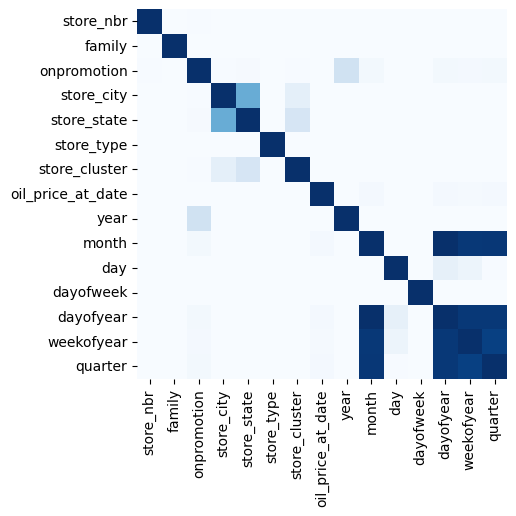

store_nbr - 0.04
family - -0.11
onpromotion - 0.43
store_city - 0.05
store_state - 0.07
store_type - -0.10
store_cluster - 0.04
oil_price_at_date - -0.07
year - 0.08
month - 0.02
day - -0.01
dayofweek - 0.04
dayofyear - 0.02
weekofyear - 0.02
quarter - 0.02


In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

corr = train_data.corr()
ax1 = sns.heatmap(corr, cbar=0, linewidths=0, vmax=1, vmin=0, square=True, cmap="Blues")
plt.show()

for column in train_data.columns:
    corr, _ = pearsonr(train_data[column], train_labels)
    print(f"{column} - {corr:.2f}")

### GradientBoostingRegressor

In [58]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

def model_gbr():
    param_grid = {
        # "n_estimators": [100, 250, 300, 350, 400, 450, 500, 1000, 2000],
        # "max_depth": [3, 4, 5, 6, 7],
        # "min_samples_split": [2, 3, 4, 5],
        # "min_samples_leaf": [1, 2, 3, 4, 5],
        # "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1],
    }
    
    return grid_search(
        GBR(
            random_state=RANDOM_STATE, 
            # n_estimators=300, 
            # max_depth=4, 
            # min_samples_split=4,
            # min_samples_leaf=2,
            # learning_rate=0.1,
        ),
        param_grid,
        train_data,
        train_labels,
    )

### Подбор гиперпараметров и создание сабмишеннов

In [59]:
submissions_folder = "submissions"

items = list(globals().items())

for name, func in items:
    if callable(func) and name.startswith("model_"):
        model, score = func()
        create_submission(
            model, f"{submissions_folder}/{1-score:.4f}_{model.__class__.__name__}"
        )

Fitting 10 folds for each of 1 candidates, totalling 10 fits


### Вычисление SMSE

In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmse_score(model, X, y):
    return rmse(y, model.predict(X))

### Сравниваем с ~100% результатом

In [ ]:
import os

submission_100 = pd.read_csv(f"{input_path}/100_score.csv")

for submission_fn in os.listdir(submissions_folder):
    if submission_fn.endswith(".csv"):
        submission = pd.read_csv(f"{submissions_folder}/{submission_fn}")

        accuracy = rmse(np.log(submission_100["SalePrice"]), np.log(submission["SalePrice"]))
        model_name = submission_fn.split('_')[-1].split('.')[0]
        old_accuracy = submission_fn.split('_')[0]
        accuracy = f"{accuracy:.4f}"

        if os.path.exists(f"{submissions_folder}/{accuracy}_{model_name}.csv"):
            print(f"{submission_fn} > {accuracy}_{model_name}.csv ALREADY EXISTS, REMOVE THIS BASTARD!!!!!!!!!!!")
            continue

        print(f"{model_name}: {accuracy}")
        os.rename(f"{submissions_folder}/{submission_fn}", f"{submissions_folder}/{accuracy}_{model_name}.csv")